In [18]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import torchvision.utils as vutils
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [19]:
torch.manual_seed(42)
np.random.seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
os.makedirs("outputs", exist_ok=True)
print(f"Using device: {device}")

Using device: cuda


In [20]:
class_names = [
    "T-shirt/top","Trouser","Pullover","Dress","Coat",
    "Sandal","Shirt","Sneaker","Bag","Ankle boot"
]

In [21]:
class FashionCNN(nn.Module):
    def __init__(self, dropout=0.5):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool  = nn.MaxPool2d(2, 2)
        self.relu  = nn.ReLU(inplace=True)

        self.fc1 = nn.Linear(64*7*7, 128)
        self.drop = nn.Dropout(dropout)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.drop(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

    def get_conv1_weights(self):
        return self.conv1.weight.data.cpu()

In [22]:

class FashionCNNDeeper(nn.Module):
    def __init__(self, dropout=0.5):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool  = nn.MaxPool2d(2, 2)
        self.relu  = nn.ReLU(inplace=True)

        self.fc1 = nn.Linear(128*7*7, 256)
        self.drop = nn.Dropout(dropout)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = self.drop(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

    def get_conv1_weights(self):
        return self.conv1.weight.data.cpu()

In [23]:
def load_data(batch_size=64):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    full_train = datasets.FashionMNIST(root="./data", train=True, download=True, transform=transform)
    train_size = int(0.9 * len(full_train))
    val_size = len(full_train) - train_size
    train_ds, val_ds = random_split(full_train, [train_size, val_size], generator=torch.Generator().manual_seed(42))
    test_ds = datasets.FashionMNIST(root="./data", train=False, download=True, transform=transform)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=2)
    val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=2)
    test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, num_workers=2)

    print(f"Train: {len(train_ds)} | Val: {len(val_ds)} | Test: {len(test_ds)}")
    return train_loader, val_loader, test_loader

In [24]:
def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    loss_sum, correct, total = 0.0, 0, 0
    for images, labels in tqdm(loader, desc="Training", leave=False):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        preds = logits.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return loss_sum / len(loader), 100.0 * correct / total

In [25]:

def evaluate(model, loader, criterion):
    model.eval()
    loss_sum, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            logits = model(images)
            loss_sum += criterion(logits, labels).item()
            preds = logits.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return loss_sum / len(loader), 100.0 * correct / total


In [26]:

def train_model(model, train_loader, val_loader, epochs=20, lr=1e-3, opt_type="Adam", save_path="outputs/best.pth"):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr) if opt_type == "Adam" else optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
    best_val, best_epoch = 0.0, -1

    for epoch in range(1, epochs + 1):
        print(f"\nEpoch {epoch}/{epochs}")
        tr_loss, tr_acc = train_one_epoch(model, train_loader, criterion, optimizer)
        va_loss, va_acc = evaluate(model, val_loader, criterion)

        history["train_loss"].append(tr_loss)
        history["train_acc"].append(tr_acc)
        history["val_loss"].append(va_loss)
        history["val_acc"].append(va_acc)

        print(f"  Train  - Loss: {tr_loss:.4f} | Acc: {tr_acc:.2f}%")
        print(f"  Val    - Loss: {va_loss:.4f} | Acc: {va_acc:.2f}%")

        if va_acc > best_val:
            best_val, best_epoch = va_acc, epoch
            torch.save(model.state_dict(), save_path)

    print(f"\nBest Val Acc: {best_val:.2f}% (epoch {best_epoch})")
    return history, best_val


In [27]:
def plot_curves(history, title, save_as):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))
    ep = range(1, len(history["train_loss"]) + 1)
    ax1.plot(ep, history["train_loss"], label="Train")
    ax1.plot(ep, history["val_loss"],   label="Val")
    ax1.set_title("Loss"); ax1.set_xlabel("Epoch"); ax1.set_ylabel("Loss"); ax1.legend(); ax1.grid(alpha=.3)

    ax2.plot(ep, history["train_acc"], label="Train")
    ax2.plot(ep, history["val_acc"],   label="Val")
    ax2.set_title("Accuracy"); ax2.set_xlabel("Epoch"); ax2.set_ylabel("Acc (%)"); ax2.legend(); ax2.grid(alpha=.3)

    plt.suptitle(title, y=1.02)
    plt.tight_layout()
    fig.savefig(save_as, dpi=300, bbox_inches="tight")
    plt.show()
    plt.close(fig)

In [28]:

def test_predictions(model, test_loader):
    model.eval()
    preds, labels, imgs = [], [], []
    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            logits = model(x)
            probs  = torch.softmax(logits, dim=1)
            p      = probs.argmax(1).cpu().numpy()
            preds.extend(p)
            labels.extend(y.numpy())
            imgs.extend(x.cpu().numpy())
    return np.array(preds), np.array(labels), np.array(imgs)


In [29]:

def plot_confmat(y_true, y_pred, save_as):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names,
                ax=ax, cbar_kws={'label': 'Count'})
    ax.set_xlabel("Predicted"); ax.set_ylabel("True"); ax.set_title("Confusion Matrix (Test)")
    fig.savefig(save_as, dpi=300, bbox_inches="tight")
    plt.show()
    plt.close(fig)

    per_class = cm.diagonal() / cm.sum(axis=1) * 100.0
    print("\nPer-class accuracy:")
    for name, acc in zip(class_names, per_class):
        print(f"  {name:15s}: {acc:.2f}%")

In [30]:

def show_misclassified(imgs, y_true, y_pred, k=3, save_as="outputs/misclassified_examples.png"):
    wrong = np.where(y_true != y_pred)[0]
    if len(wrong) == 0:
        print("No misclassified examples.")
        return
    idx = np.random.choice(wrong, size=min(k, len(wrong)), replace=False)
    fig, axes = plt.subplots(1, len(idx), figsize=(5*len(idx), 5))
    if len(idx) == 1:
        axes = [axes]
    for i, ax in zip(idx, axes):
        img = imgs[i].squeeze() * 0.5 + 0.5
        ax.imshow(img, cmap="gray"); ax.axis("off")
        ax.set_title(f"True: {class_names[y_true[i]]}\nPred: {class_names[y_pred[i]]}", color="red")
    plt.suptitle("Misclassified examples", y=0.98)
    plt.tight_layout()
    plt.savefig(save_as, dpi=300, bbox_inches="tight")
    plt.show()
    plt.close()


In [31]:

def visualize_filters(model, save_as="outputs/learned_filters.png"):
    w = model.get_conv1_weights()             # [32,1,3,3]
    w = (w - w.min()) / (w.max() - w.min() + 1e-8)
    grid = vutils.make_grid(w, nrow=8, normalize=False, padding=1)  # [C,H,W]
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.imshow(grid.permute(1,2,0).squeeze(), cmap="viridis")
    ax.axis("off"); ax.set_title("Conv1 filters")
    fig.savefig(save_as, dpi=300, bbox_inches="tight")
    plt.show()
    plt.close(fig)

In [32]:
def visualize_feature_maps(model, one_image_np, save_as="outputs/feature_maps.png"):
    model.eval()
    acts = []

    def hook(_m, _i, o): acts.append(o)

    h1 = model.conv1.register_forward_hook(hook)
    h2 = model.conv2.register_forward_hook(hook)

    x = torch.from_numpy(one_image_np).unsqueeze(0).to(device)  # [1,1,28,28]
    with torch.no_grad():
        _ = model(x)

    h1.remove(); h2.remove()

    fig, axes = plt.subplots(3, 1, figsize=(15, 12))
    img = one_image_np.squeeze() * 0.5 + 0.5
    axes[0].imshow(img, cmap="gray"); axes[0].axis("off"); axes[0].set_title("Original")

    f1 = acts[0][0, :16].cpu()
    g1 = vutils.make_grid(f1.unsqueeze(1), nrow=8, normalize=True, padding=2)
    axes[1].imshow(g1.permute(1,2,0).squeeze(), cmap="viridis")
    axes[1].axis("off"); axes[1].set_title("Conv1 (first 16)")

    f2 = acts[1][0, :16].cpu()
    g2 = vutils.make_grid(f2.unsqueeze(1), nrow=8, normalize=True, padding=2)
    axes[2].imshow(g2.permute(1,2,0).squeeze(), cmap="viridis")
    axes[2].axis("off"); axes[2].set_title("Conv2 (first 16)")

    plt.tight_layout()
    plt.savefig(save_as, dpi=300, bbox_inches="tight")
    plt.show()
    plt.close()


In [33]:

def main():
    print("="*68)
    print("FASHION-MNIST CNN: BASELINE VS DEEPER")
    print("="*68)

    train_loader, val_loader, test_loader = load_data(batch_size=64)

    #Baseline
    baseline = FashionCNN().to(device)
    print(f"\nBaseline params: {sum(p.numel() for p in baseline.parameters()):,}")
    hist_base, best_base = train_model(
        baseline, train_loader, val_loader,
        epochs=20, lr=1e-3, opt_type="Adam",
        save_path="outputs/best_baseline.pth"
    )
    plot_curves(hist_base, "Baseline (2 conv) - Train/Val", "outputs/baseline_training_curves.png")

    #Deeper
    deeper = FashionCNNDeeper().to(device)
    print(f"\nDeeper params:   {sum(p.numel() for p in deeper.parameters()):,}")
    hist_deep, best_deep = train_model(
        deeper, train_loader, val_loader,
        epochs=20, lr=1e-3, opt_type="Adam",
        save_path="outputs/best_deeper.pth"
    )
    plot_curves(hist_deep, "Deeper (3 conv) - Train/Val", "outputs/deeper_model_training_curves.png")

    #Side-by-side comparison plot
    fig, axes = plt.subplots(1, 2, figsize=(13, 5))
    ep = range(1, len(hist_base["val_loss"]) + 1)
    axes[0].plot(ep, hist_base["val_loss"], label="Baseline")
    axes[0].plot(ep, hist_deep["val_loss"], label="Deeper")
    axes[0].set_title("Validation Loss"); axes[0].set_xlabel("Epoch"); axes[0].set_ylabel("Loss"); axes[0].legend(); axes[0].grid(alpha=.3)
    axes[1].plot(ep, hist_base["val_acc"], label="Baseline")
    axes[1].plot(ep, hist_deep["val_acc"], label="Deeper")
    axes[1].set_title("Validation Accuracy"); axes[1].set_xlabel("Epoch"); axes[1].set_ylabel("Acc (%)"); axes[1].legend(); axes[1].grid(alpha=.3)
    plt.suptitle("Hyperparameter: Network Depth", y=1.02)
    plt.tight_layout()
    fig.savefig("outputs/hyperparameter_comparison.png", dpi=300, bbox_inches="tight")
    plt.show()
    plt.close(fig)


    if best_base >= best_deep:
        model_name = "Baseline (2 conv)"
        best_model = FashionCNN().to(device)
        best_model.load_state_dict(torch.load("outputs/best_baseline.pth", map_location=device))
        best_hist = hist_base
    else:
        model_name = "Deeper (3 conv)"
        best_model = FashionCNNDeeper().to(device)
        best_model.load_state_dict(torch.load("outputs/best_deeper.pth", map_location=device))
        best_hist = hist_deep

    preds, labels, imgs = test_predictions(best_model, test_loader)
    test_acc = 100.0 * (preds == labels).sum() / len(labels)
    print(f"\nSelected model: {model_name} | Test Acc: {test_acc:.2f}%")

    plot_confmat(labels, preds, "outputs/confusion_matrix.png")
    show_misclassified(imgs, labels, preds, k=3, save_as="outputs/misclassified_examples.png")


    visualize_filters(best_model, "outputs/learned_filters.png")
    rnd = np.random.randint(0, len(imgs))
    visualize_feature_maps(best_model, imgs[rnd], "outputs/feature_maps.png")

FASHION-MNIST CNN: BASELINE VS DEEPER
Train: 54000 | Val: 6000 | Test: 10000

Baseline params: 421,642

Epoch 1/20


  Train  - Loss: 0.5621 | Acc: 79.83%
  Val    - Loss: 0.3633 | Acc: 86.22%

Epoch 2/20


  Train  - Loss: 0.3711 | Acc: 86.79%
  Val    - Loss: 0.2911 | Acc: 89.63%

Epoch 3/20


  Train  - Loss: 0.3163 | Acc: 88.83%
  Val    - Loss: 0.2571 | Acc: 90.55%

Epoch 4/20


  Train  - Loss: 0.2812 | Acc: 89.86%
  Val    - Loss: 0.2470 | Acc: 90.68%

Epoch 5/20


  Train  - Loss: 0.2541 | Acc: 90.82%
  Val    - Loss: 0.2248 | Acc: 91.95%

Epoch 6/20


  Train  - Loss: 0.2382 | Acc: 91.43%
  Val    - Loss: 0.2364 | Acc: 91.62%

Epoch 7/20


  Train  - Loss: 0.2192 | Acc: 91.95%
  Val    - Loss: 0.2152 | Acc: 91.88%

Epoch 8/20


  Train  - Loss: 0.2033 | Acc: 92.54%
  Val    - Loss: 0.2292 | Acc: 91.87%

Epoch 9/20


  Train  - Loss: 0.1927 | Acc: 92.94%
  Val    - Loss: 0.2160 | Acc: 92.37%

Epoch 10/20


  Train  - Loss: 0.1802 | Acc: 93.35%
  Val    - Loss: 0.2149 | Acc: 92.63%

Epoch 11/20


  Train  - Loss: 0.1691 | Acc: 93.59%
  Val    - Loss: 0.2186 | Acc: 92.62%

Epoch 12/20


  Train  - Loss: 0.1594 | Acc: 93.99%
  Val    - Loss: 0.2202 | Acc: 92.80%

Epoch 13/20


  Train  - Loss: 0.1512 | Acc: 94.31%
  Val    - Loss: 0.2160 | Acc: 92.68%

Epoch 14/20


  Train  - Loss: 0.1404 | Acc: 94.66%
  Val    - Loss: 0.2272 | Acc: 92.58%

Epoch 15/20


  Train  - Loss: 0.1342 | Acc: 94.88%
  Val    - Loss: 0.2299 | Acc: 92.50%

Epoch 16/20


  Train  - Loss: 0.1281 | Acc: 95.14%
  Val    - Loss: 0.2399 | Acc: 92.88%

Epoch 17/20


  Train  - Loss: 0.1248 | Acc: 95.27%
  Val    - Loss: 0.2574 | Acc: 92.28%

Epoch 18/20


  Train  - Loss: 0.1152 | Acc: 95.60%
  Val    - Loss: 0.2514 | Acc: 92.47%

Epoch 19/20


  Train  - Loss: 0.1106 | Acc: 95.77%
  Val    - Loss: 0.2499 | Acc: 92.50%

Epoch 20/20


  Train  - Loss: 0.1055 | Acc: 95.85%
  Val    - Loss: 0.2637 | Acc: 92.67%

Best Val Acc: 92.88% (epoch 16)


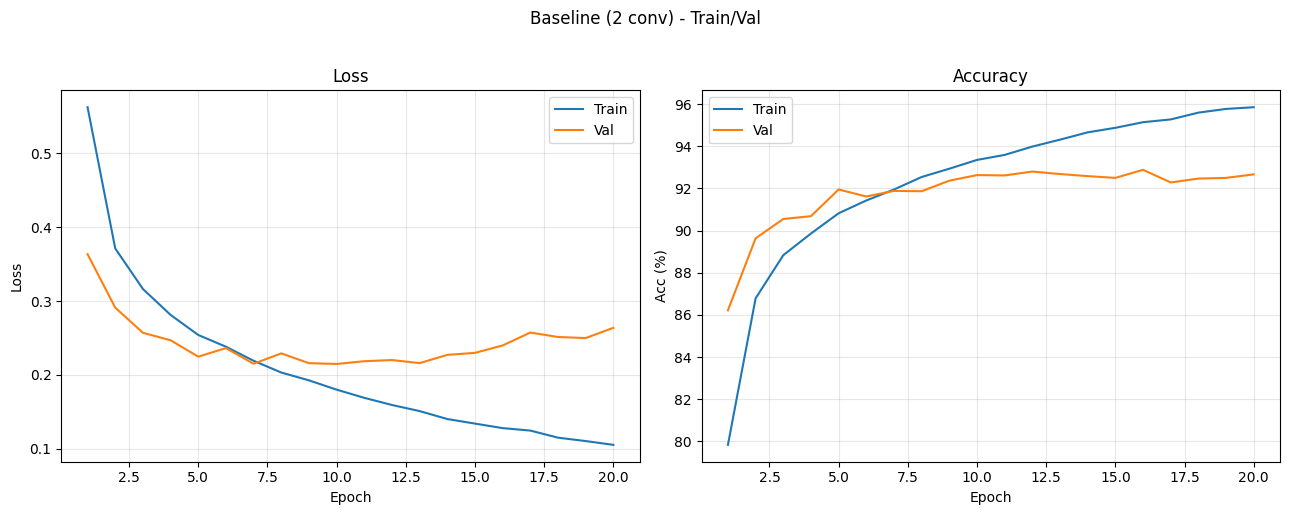


Deeper params:   1,701,130

Epoch 1/20


  Train  - Loss: 0.4966 | Acc: 81.99%
  Val    - Loss: 0.3082 | Acc: 88.73%

Epoch 2/20


  Train  - Loss: 0.3126 | Acc: 88.74%
  Val    - Loss: 0.2630 | Acc: 90.22%

Epoch 3/20


  Train  - Loss: 0.2650 | Acc: 90.39%
  Val    - Loss: 0.2421 | Acc: 90.75%

Epoch 4/20


  Train  - Loss: 0.2330 | Acc: 91.48%
  Val    - Loss: 0.2287 | Acc: 91.33%

Epoch 5/20


  Train  - Loss: 0.2056 | Acc: 92.52%
  Val    - Loss: 0.2244 | Acc: 91.78%

Epoch 6/20


  Train  - Loss: 0.1847 | Acc: 93.19%
  Val    - Loss: 0.2157 | Acc: 92.52%

Epoch 7/20


  Train  - Loss: 0.1666 | Acc: 93.86%
  Val    - Loss: 0.2099 | Acc: 92.33%

Epoch 8/20


  Train  - Loss: 0.1471 | Acc: 94.47%
  Val    - Loss: 0.2134 | Acc: 92.50%

Epoch 9/20


  Train  - Loss: 0.1319 | Acc: 95.10%
  Val    - Loss: 0.2211 | Acc: 92.13%

Epoch 10/20


  Train  - Loss: 0.1169 | Acc: 95.56%
  Val    - Loss: 0.2336 | Acc: 92.28%

Epoch 11/20


  Train  - Loss: 0.1043 | Acc: 96.05%
  Val    - Loss: 0.2301 | Acc: 92.25%

Epoch 12/20


  Train  - Loss: 0.0963 | Acc: 96.37%
  Val    - Loss: 0.2447 | Acc: 92.45%

Epoch 13/20


  Train  - Loss: 0.0798 | Acc: 96.95%
  Val    - Loss: 0.2672 | Acc: 92.73%

Epoch 14/20


  Train  - Loss: 0.0764 | Acc: 97.11%
  Val    - Loss: 0.2880 | Acc: 92.80%

Epoch 15/20


  Train  - Loss: 0.0732 | Acc: 97.23%
  Val    - Loss: 0.2812 | Acc: 92.88%

Epoch 16/20


  Train  - Loss: 0.0648 | Acc: 97.59%
  Val    - Loss: 0.2882 | Acc: 92.55%

Epoch 17/20


  Train  - Loss: 0.0617 | Acc: 97.68%
  Val    - Loss: 0.2982 | Acc: 92.88%

Epoch 18/20


  Train  - Loss: 0.0582 | Acc: 97.88%
  Val    - Loss: 0.3199 | Acc: 92.82%

Epoch 19/20


  Train  - Loss: 0.0514 | Acc: 98.08%
  Val    - Loss: 0.3282 | Acc: 92.72%

Epoch 20/20


  Train  - Loss: 0.0540 | Acc: 98.00%
  Val    - Loss: 0.3368 | Acc: 92.95%

Best Val Acc: 92.95% (epoch 20)


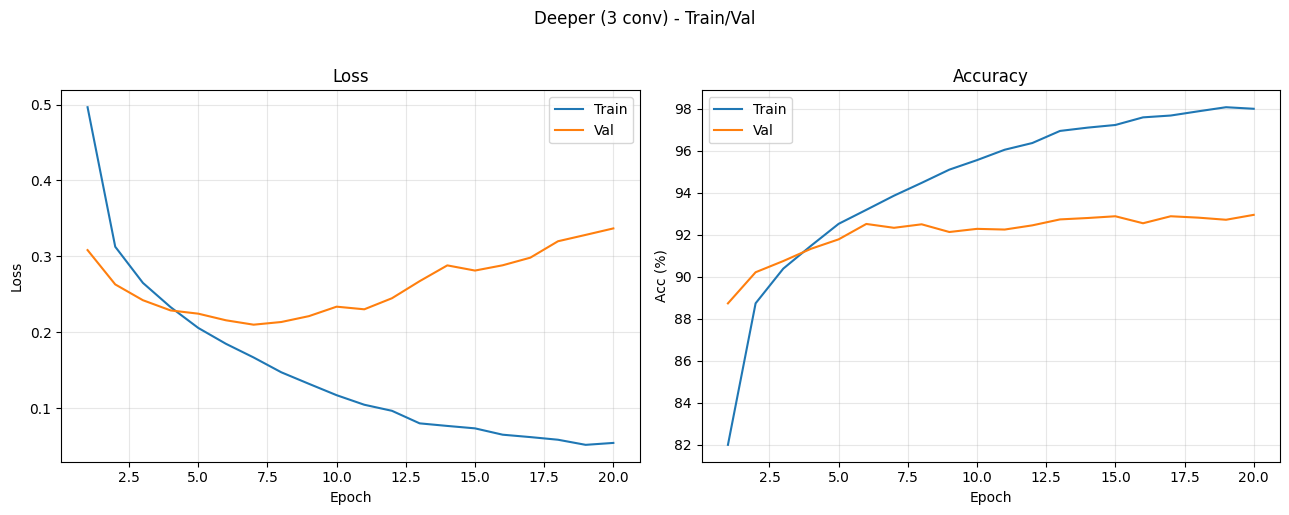

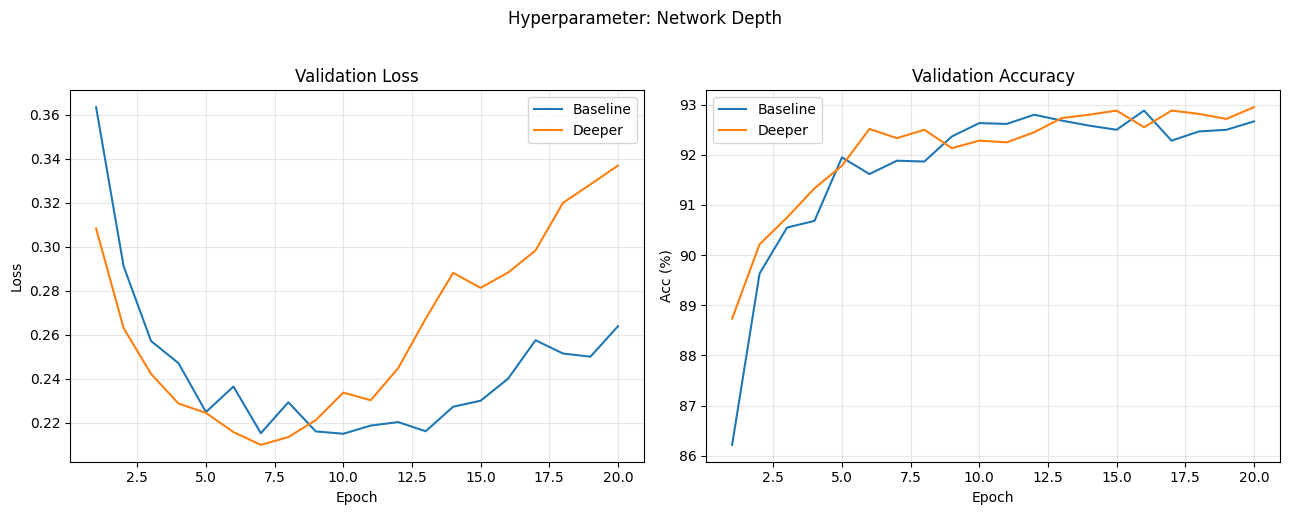


Selected model: Deeper (3 conv) | Test Acc: 92.23%


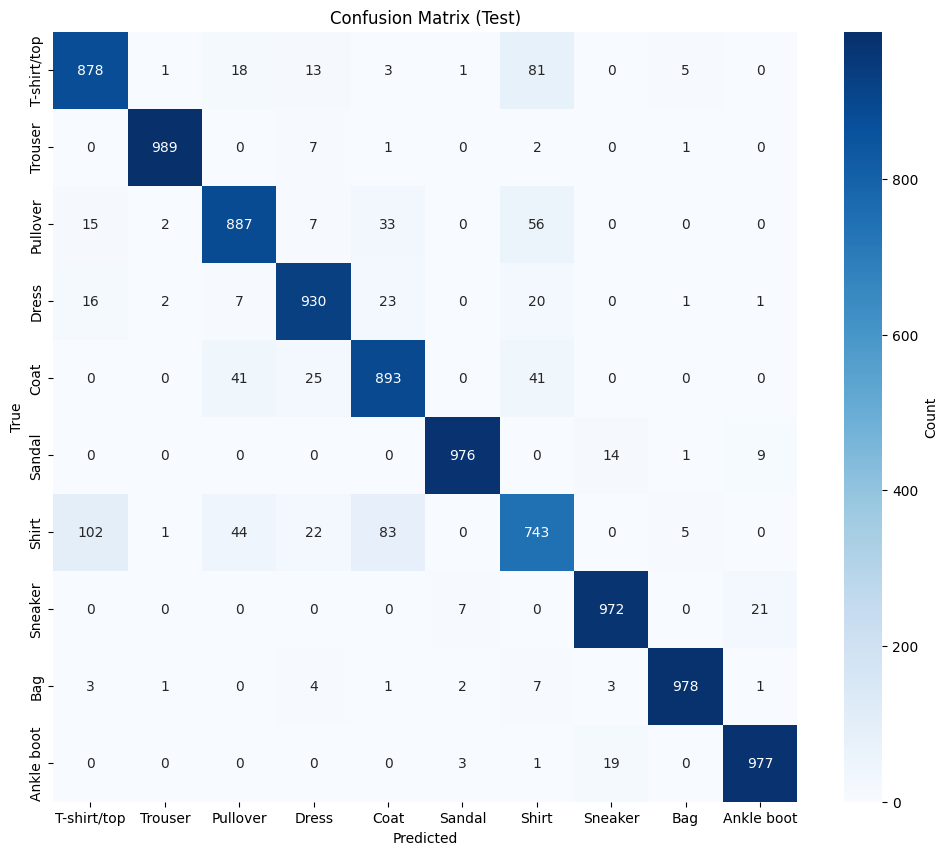


Per-class accuracy:
  T-shirt/top    : 87.80%
  Trouser        : 98.90%
  Pullover       : 88.70%
  Dress          : 93.00%
  Coat           : 89.30%
  Sandal         : 97.60%
  Shirt          : 74.30%
  Sneaker        : 97.20%
  Bag            : 97.80%
  Ankle boot     : 97.70%


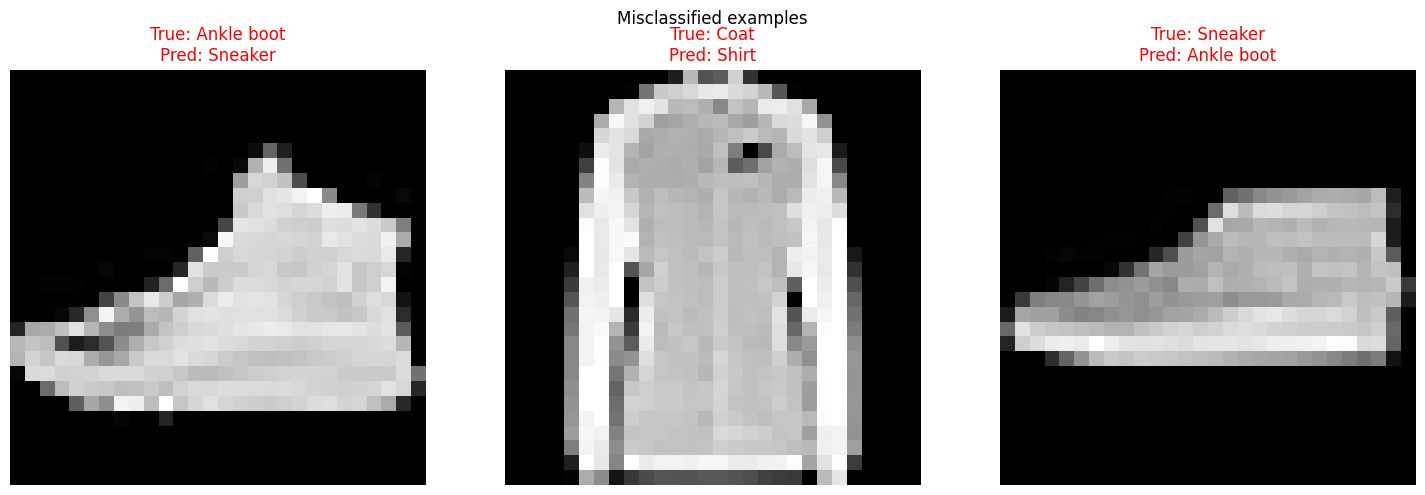

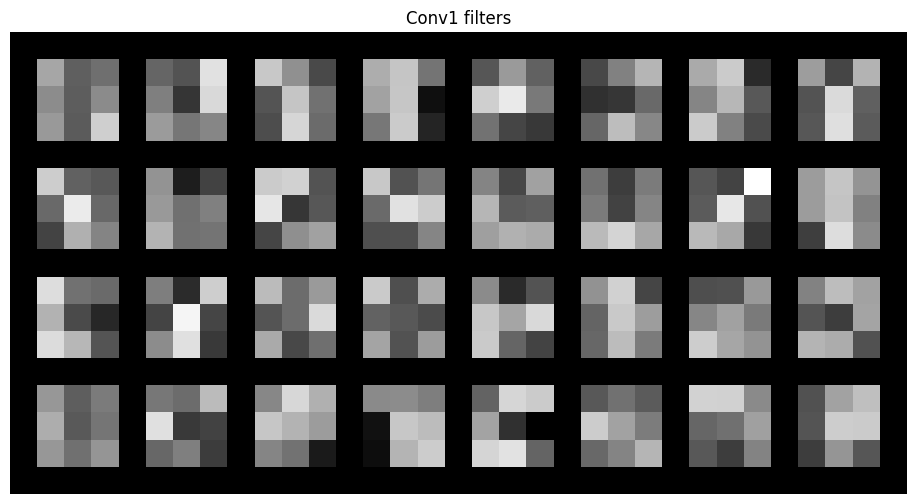

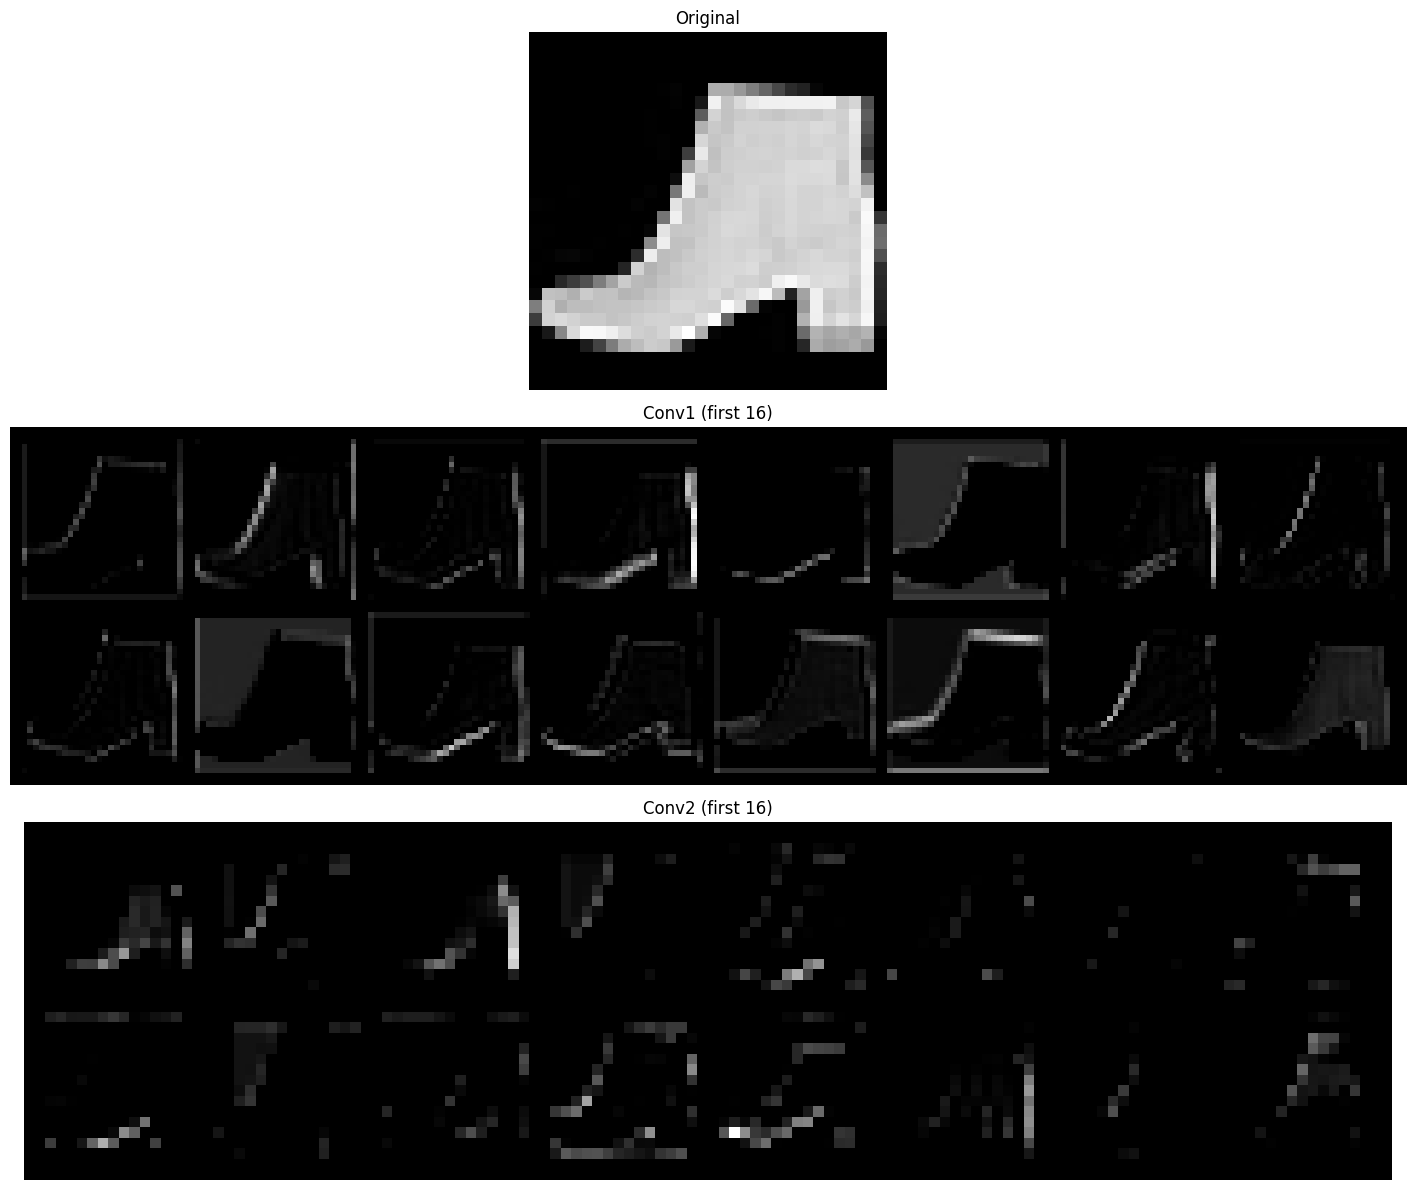

In [34]:

if __name__ == "__main__":
    main()